# Data pre-processing on the GAMS dataset

In this notebook, the data from the gams dataset are loaded and pre-processed so that they can be used for training machine learning models. The processed data re written in a csv file for direct access

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

# setting plot styles
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["font.size"] = 22

## Data importing and basic pre-processing

In [2]:
gams_url = 'https://raw.githubusercontent.com/twairball/gams-dataset/master/gams_indoor.csv'
gams_df = pd.read_csv(gams_url, index_col='ts')
gams_df.head()

,co2,humidity,pm10,pm25,temperature,voc
ts,,,,,,
2016-11-21 00:47:03,708.0,72.09,10.2,9.0,20.83,0.062
2016-11-21 00:48:03,694.0,70.95,10.9,10.1,21.01,0.062
2016-11-21 00:49:03,693.0,69.12,10.2,9.9,21.20,0.062
2016-11-21 00:50:03,692.0,68.83,9.6,9.6,21.37,0.062
2016-11-21 00:51:03,690.0,68.60,9.4,8.4,21.49,0.062


In [3]:
gams_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135099 entries, 2016-11-21 00:47:03 to 2017-03-28 09:30:03
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   co2          135099 non-null  float64
 1   humidity     135099 non-null  float64
 2   pm10         135099 non-null  float64
 3   pm25         135099 non-null  float64
 4   temperature  135099 non-null  float64
 5   voc          135099 non-null  float64
dtypes: float64(6)
memory usage: 7.2+ MB


In [4]:
gams_df.describe()

,co2,humidity,pm10,pm25,temperature,voc
count,135099.000000,135099.000000,135099.000000,135099.000000,135099.000000,135099.000000
mean,688.833011,37.879496,17.553535,15.801651,22.939613,0.121050
std,385.845573,5.284216,12.603744,11.709474,2.051068,0.089947
min,369.000000,21.970000,0.500000,0.500000,17.710000,0.062000
25%,429.000000,34.490000,8.400000,7.300000,21.410000,0.064000
50%,483.000000,37.640000,14.000000,12.300000,22.860000,0.076000
75%,852.000000,41.290000,23.400000,21.000000,24.650000,0.149000
max,2626.000000,72.090000,142.600000,85.200000,27.960000,2.000000


Convert to hourly observations

In [5]:
gams_df.index = pd.to_datetime(gams_df.index) # convert index to datetime object
gams_df.drop('pm10', axis=1, inplace=True) # delete PM10
gams_hourly_df = gams_df.resample('60min').mean() # resample to hourly observations
print("Data points after resampling: {}".format(gams_hourly_df.shape[0]))
print(gams_hourly_df.head())

Data points after resampling: 3058
                             co2   humidity       pm25  temperature       voc
ts                                                                           
2016-11-21 00:00:00   693.846154  68.351538   7.900000    21.731538  0.062000
2016-11-21 01:00:00   760.377778  61.866000   5.151111    24.032889  0.062889
2016-11-21 02:00:00  1174.200000  59.996400  12.840000    25.877200  0.063200
2016-11-21 03:00:00  1397.740741  59.742963  18.666667    26.562963  0.066222
2016-11-21 04:00:00  1413.727273  58.885455  11.272727    26.835909  0.062773


Normalizing the data in the range [0,1]

In [6]:
timestamps = gams_hourly_df.index
scaler = MinMaxScaler()
gams_hourly_normed = scaler.fit_transform(gams_hourly_df) # result is numpy array
gams_hourly_df = pd.DataFrame(gams_hourly_normed, columns=gams_df.columns, index=timestamps) # re-write bac to the original dataframe
gams_hourly_df.head()

,co2,humidity,pm25,temperature,voc
ts,,,,,
2016-11-21 00:00:00,0.146154,1.000000,0.099312,0.368924,2.775558e-17
2016-11-21 01:00:00,0.176426,0.859655,0.061219,0.603804,1.403140e-03
2016-11-21 02:00:00,0.364717,0.819198,0.167767,0.792038,1.894238e-03
2016-11-21 03:00:00,0.466429,0.813714,0.248510,0.862028,6.664913e-03
2016-11-21 04:00:00,0.473703,0.795158,0.146049,0.889885,1.219775e-03


In [7]:
gams_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3058 entries, 2016-11-21 00:00:00 to 2017-03-28 09:00:00
Freq: 60T
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   co2          2998 non-null   float64
 1   humidity     2998 non-null   float64
 2   pm25         2998 non-null   float64
 3   temperature  2998 non-null   float64
 4   voc          2998 non-null   float64
dtypes: float64(5)
memory usage: 143.3 KB


Visualizing missing values

Rows with at least one nan: 


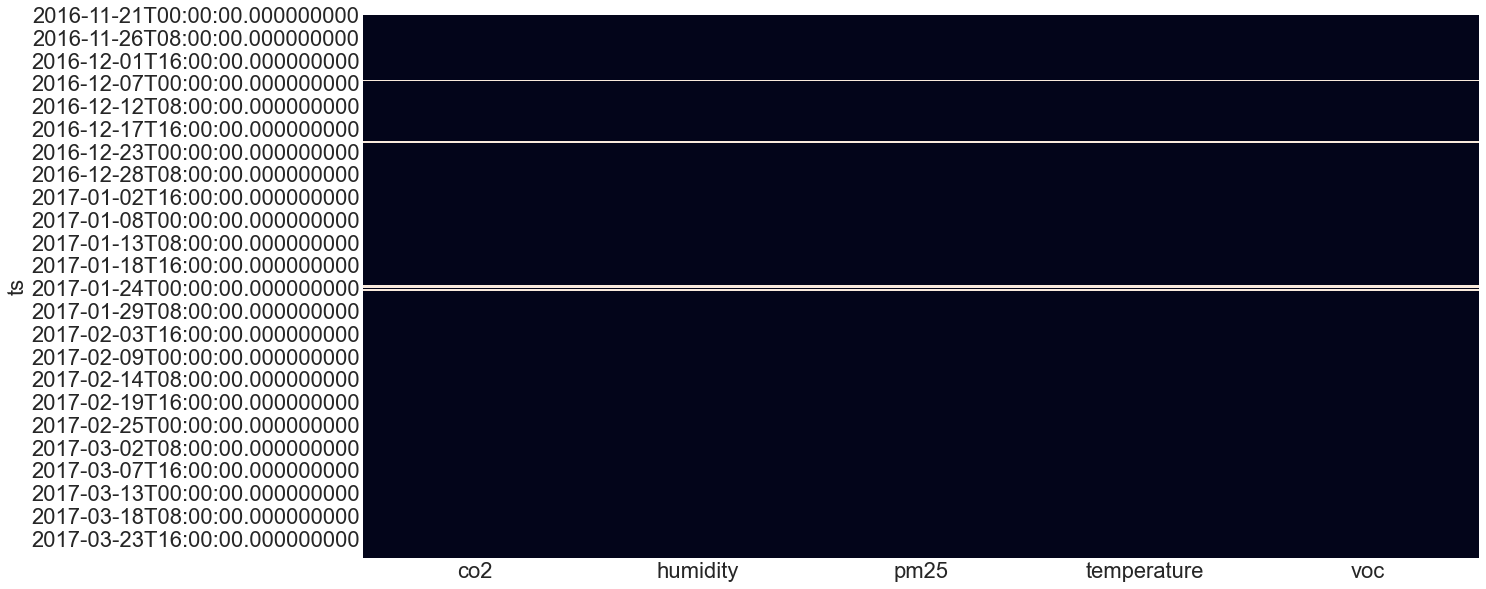

In [8]:
nulls_df = gams_hourly_df.isnull()
print("Rows with at least one nan: ")
# print(np.where(np.asanyarray(np.isnan(gams_hourly_df)))[0])
sns.heatmap(nulls_df, cbar=False); # distribution of nans

Filling missing values using k-nn imputation

In [9]:
# gams_hourly_df.fillna(gams_hourly_df.mean(), inplace=True)

def knn_imputation(df):
    """ Imputes missing values based on the k-nn method

        INPUT: df = a dataframe

        OUTPUT: df_filled = a numpy array withn nan's filled
    """

    from sklearn.impute import KNNImputer
    k = int(round(np.sqrt(len(df))))
    # print(k)
    imputer = KNNImputer(n_neighbors=k)
    df_filled = imputer.fit_transform(df)

    return df_filled


gams_hourly_filled = knn_imputation(gams_hourly_df) # returns numpy array
gams_hourly_df = pd.DataFrame(gams_hourly_filled, columns=gams_df.columns, index=timestamps) # write back to the original dataframe
gams_hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3058 entries, 2016-11-21 00:00:00 to 2017-03-28 09:00:00
Freq: 60T
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   co2          3058 non-null   float64
 1   humidity     3058 non-null   float64
 2   pm25         3058 non-null   float64
 3   temperature  3058 non-null   float64
 4   voc          3058 non-null   float64
dtypes: float64(5)
memory usage: 143.3 KB


**Write processed data to csv**

In [10]:
gams_hourly_df.head()

,co2,humidity,pm25,temperature,voc
ts,,,,,
2016-11-21 00:00:00,0.146154,1.000000,0.099312,0.368924,2.775558e-17
2016-11-21 01:00:00,0.176426,0.859655,0.061219,0.603804,1.403140e-03
2016-11-21 02:00:00,0.364717,0.819198,0.167767,0.792038,1.894238e-03
2016-11-21 03:00:00,0.466429,0.813714,0.248510,0.862028,6.664913e-03
2016-11-21 04:00:00,0.473703,0.795158,0.146049,0.889885,1.219775e-03


In [11]:
gams_hourly_df.to_csv('gams_processed.csv', index=True)

**Example of reading the csv file**

In [12]:
gams_pr_df = pd.read_csv('gams_processed.csv')
gams_pr_df.head()

,ts,co2,humidity,pm25,temperature,voc
0,2016-11-21 00:00:00,0.146154,1.000000,0.099312,0.368924,2.775558e-17
1,2016-11-21 01:00:00,0.176426,0.859655,0.061219,0.603804,1.403140e-03
2,2016-11-21 02:00:00,0.364717,0.819198,0.167767,0.792038,1.894238e-03
3,2016-11-21 03:00:00,0.466429,0.813714,0.248510,0.862028,6.664913e-03
4,2016-11-21 04:00:00,0.473703,0.795158,0.146049,0.889885,1.219775e-03
